In [1]:
import numpy as np
np.set_printoptions(precision=2)
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from matplotlib.offsetbox import AnchoredText

from scipy.stats import bootstrap #Need Scipy 1.8.0
from scipy.stats import poisson

In [2]:
#For formatting for interation.yamls
def MatrixString(matrix):
    string = "["
    for i in range(matrix.shape[0]):
        string += "["
        for j in range(matrix.shape[1]):
            string += "%.2f" % matrix[i,j]
            if j < matrix.shape[1]-1:
                string+=","
        string+="]"
        if i < matrix.shape[0]-1:
                string+=","
    string+="]"
    return string

def PolicyText(Type, contacts, contacts_err, proportional_physical, characteristic_time):
    print("  %s:" % Type)
    print("    contacts: %s" % MatrixString(contacts))
    print("    contacts_err: %s" % MatrixString(contacts_err))
    print("    proportion_physical: %s" % MatrixString(proportional_physical))
    print("    characteristic_time: %.2f" % characteristic_time)

In [3]:
data_file = "../../Downloaded_Items/UNHCR BGD 2020 Protection Measures COVID 19.csv"

In [4]:
data = pd.read_csv(data_file)
NPop = np.array([295901,274933]) #N children N Adults

NPopMF = np.array([276608, 294226])

print(f"Children are {NPop[0] / (NPop[0]+NPop[1])}% of population")
print(f"Adults are {NPop[1] / (NPop[0]+NPop[1])}% of population")

print(f"Men are {NPopMF[0] / (NPopMF[0]+NPopMF[1])}% of population")
print(f"Women are {NPopMF[1] / (NPopMF[0]+NPopMF[1])}% of population")

Children are 0.5183661099373899% of population
Adults are 0.48163389006261015% of population
Men are 0.4845681932050298% of population
Women are 0.5154318067949701% of population


In [5]:
#Loop over all possible time spent answers to create list.
TimeCols = ["education_time", "education_time77", 'distcenter_time',
       'distcenter_time77', 'evoucher_time', 'evoucher_time77','community_time', 'community_time77', 'religious_time', 'religious_time_77','pump_time',
       'pump_time77']
AllTimeAnswers=[]
for whichtime in TimeCols:
    Key, _ = np.unique(data[whichtime].dropna(), return_counts=True)
    AllTimeAnswers += list(Key)
    
KeysAll = list(set(AllTimeAnswers))
#Print with correct formatting for look-up dictionary
for i in KeysAll:
    print("'%s' : ," % i) 

'30mins in water pumps and 15min in latrine' : ,
'3 hrs' : ,
'24' : ,
'10 min' : ,
'3â€“5 minutes ' : ,
'15min' : ,
'2 hours' : ,
'40 minutes ' : ,
'30' : ,
'2 to 3 min ' : ,
'0 minutes' : ,
'4 hour ' : ,
'5 to 10' : ,
'4' : ,
'35 minutes ' : ,
'20minutes' : ,
'50min' : ,
'45 min' : ,
'3 to 5 min' : ,
'15 minutes ' : ,
'7 minutes' : ,
'30 min' : ,
'15 minutes' : ,
'20 to 25 minutes ' : ,
'30mins water pumps and 15mins in latrine' : ,
'3 hours' : ,
'20minit' : ,
'10 minute' : ,
'2 hour ' : ,
'20 min' : ,
'30 minute ' : ,
'10 to 15 minutes ' : ,
'40min' : ,
'20' : ,
'15mins' : ,
'30mins in water pumps and 15mins in latrin' : ,
'half an hour' : ,
'5 minutes' : ,
'12 minutes ' : ,
'10 to 20 min' : ,
'30minutes' : ,
'3min' : ,
'50 minutes ' : ,
'29minutes' : ,
'35minutes' : ,
'20 minute ' : ,
'25mi' : ,
'40mnt' : ,
'2 minutes' : ,
'2.5 hours' : ,
'15' : ,
'1 hour' : ,
'3 hour ' : ,
'18 minutes ' : ,
'10 Minutes' : ,
'10' : ,
'Need  Other  help' : ,
'45' : ,
'20 minutes' : ,
'5 to 10 min' : 

In [6]:
#Manually add keys for these!
TimeDict = {  
    np.nan : np.nan,
    '15 minutes' : 15,
    '12 minutes ' : 12,
    '3min' : 3,
    '30mins' : 30,
    '25mi' : 25,
    '5 to 10' : 7.5,
    'other' : np.nan,
    '40 minutes' : 40,
    'Half an hour' : 30,
    '5 to 10 min' : 7.5,
    '3o minutes' : 30,
    '25min' : 25,
    '30 Min' : 30,
    '15 minute' : 15,
    '5 minutes' : 5,
    '30 minute ' : 30,
    'Need  Other help ' : np.nan,
    '10 to 15 minutes ' : 12.5,
    '30 to 45 min' : 37.5,
    '24' : 24,
    '12minutes' : 12,
    '2.5 hours' : 2.5*60,
    '40mnt' : 40,
    '10 minutes' : 10,
    '0 minutes' : np.nan,
    'Need  Other  help' : np.nan,
    '10 minutes ' : 10,
    '35 minutes ' : 35,
    '40min' : 40,
    '5 Minutes' : 5,
    '30 Minutes ' : 30,
    '20 minute ' : 20,
    '30 mnt' : 30,
    '4 hour ' : 4*60,
    '20min' : 20,
    '2 to 3 min' : 2.5,
    '50min' : 50,
    '15sec' : np.nan,
    '29minutes' : 29,
    '30' : 30,
    '15 minutes ' : 15,
    '3 hrs' : 3*60,
    '17 minutes' : 17,
    '30 minutes ' : 30,
    '10  minutes ' : 10,
    '29 minutes' : 29,
    '20minit' : 20,
    '3 to 5 min' : 4,
    '7 minutes' : 7,
    '4 hour' : 4*60,
    '30mins in water pumps and 15min in latrine' : 45,
    '35minutes' : 35,
    '30minutes' : 30,
    '20 Minutes ' : 20,
    '10 Minutes' : 10,
    '50 minutes ' : 50,
    '25 minute' : 25,
    '40 minutes ' : 40,
    '15mins' : 15,
    '18 minutes ' : 18,
    '15 minute ' : 15,
    'She do not go to water pump because she has a son.' : np.nan,
    '20' : 20,
    '35 minute ' : 35,
    '45minutes' : 45,
    '1 hour and 30 minutes' : 1.5*60,
    '12 minutes' : 12,
    '15minutes' : 15,
    '5 minute' : 5,
    '3 hour ' : 3*60,
    '25 minutes' : 25,
    '30mins in water pumps and 15mins in latrin' : 45,
    '3 hours' : 3*60,
    '20/30minutes' : 25,
    '30 min' : 30,
    '1 hour' : 1*60,
    '10 min' : 10,
    '30min' : 30,
    '23' : 23,
    '2 to 3 min ' : 2.5,
    '2 minutes' : 2,
    '10 to 20 min' : 15,
    '20 minutes ' : 20,
    '34minutes' : 34,
    '45' : 45,
    '30 minutes' : 30,
    '3â€“5 minutes ' : 5,
    'half an hour ' : 30,
    '30mins water pumps and 15mins in latrine' : 45,
    '2 hours' : 2*60,
    '15min' : 15,
    'half an hour' : 30,
    '20mins in water pump and 15min in latrine' : 35,
    '20minutes' : 20,
    '4' : np.nan, #Minutes/hours?
    '4 hours' : 4*60,
    '10minutes' : 10,
    '20 min' : 20,
    '40minutes' : 40,
    '25 minutes ' : 25,
    '45 min' : 45,
    '15' : 15,
    '20 to 25 minutes ' : 22.5,
    'Half an hour.' : 30,
    '10 minute' : 10,
    '10' : 10,
    '2 hour ' : 2*60,
    '20 minutes' : 20
}

In [7]:
def child_child(data, x, OmitDisability=False):
    NotDisabledBool = True
    if OmitDisability:
        NotDisabledBool = data["disability"] == "No"
    Indexes = (data["age"] == "Under 18") * NotDisabledBool
    return (data[Indexes][x]).values, Indexes.values
    
def adult_adult(data, x, OmitDisability=False):
    NotDisabledBool = True
    if OmitDisability:
        NotDisabledBool = data["disability"] == "No"
    Indexes = (data["age"].isin(["Over 18 but under 60", "Over 60"])) * NotDisabledBool
    return (data[Indexes][x]).values, Indexes
    
def child_adult(data, x, OmitDisability=False):
    NotDisabledBool = True
    if OmitDisability:
        NotDisabledBool = data["disability"] == "No"
    Indexes = (data["age"] == "Under 18") * NotDisabledBool
    return (data[Indexes][x]).values, Indexes
    
def adult_child(data, x, OmitDisability=False):
    NotDisabledBool = True
    if OmitDisability:
        NotDisabledBool = data["disability"] == "No"
    Indexes = (data["age"].isin(["Over 18 but under 60", "Over 60"])) * NotDisabledBool
    return (data[Indexes][x]).values, Indexes

In [8]:
def Bootstrap(x, metric, confidence_level):
    res = bootstrap(
            (x,), 
            metric,  
            vectorized=False, 
            confidence_level=confidence_level,
            random_state=None, 
            method="percentile"
        )
        #print(res.confidence_interval)
    return res

def contact_matrix_error(matrix, metric=np.median, confidence_level=0.682689492137086):
    Error = np.zeros_like(matrix)
    for i in range(Error.shape[0]):
        for j in range(Error.shape[0]):
            res = Bootstrap(matrix[i,j], metric, confidence_level)
            Error[i,j] = res.standard_error
    return Error 

In [9]:
def contact_matrix(data, x, y, times, WeightMF=False, OmitDisability=False, norm=False, characteristic_time=1):
    def ProcessAndFilter(times, x_y, T_xy):
        timesgiven_xy = times[T_xy]
        sexes_xy = data[T_xy]["sex"].values
        naninf = (np.isnan(x_y) | np.isinf(x_y) | np.isnan(timesgiven_xy) | np.isinf(timesgiven_xy))

        xM_y = x_y[~naninf * (sexes_xy == "Male")]
        xF_y = x_y[~naninf * (sexes_xy == "Female")]
        x_y = x_y[~naninf * ((sexes_xy == "Male") | (sexes_xy == "Female"))]
        
        timesgiven_xMy = timesgiven_xy[~naninf * (sexes_xy == "Male")]
        timesgiven_xFy = timesgiven_xy[~naninf * (sexes_xy == "Female")]
        timesgiven_xy = timesgiven_xy[~naninf * ((sexes_xy == "Male") | (sexes_xy == "Female"))]
        
        sexes_xy = sexes_xy[~naninf * ((sexes_xy == "Male") | (sexes_xy == "Female"))]
        return x_y, sexes_xy, timesgiven_xy, xM_y, xF_y, timesgiven_xMy, timesgiven_xFy
    
    c_c, T_cc = child_child(data, x, OmitDisability) 
    c_c, sexes_cc, timesgiven_cc, cM_c, cF_c, timesgiven_cMc, timesgiven_cFc = ProcessAndFilter(times, c_c, T_cc)
    
    c_a, T_ca = child_adult(data, y, OmitDisability)
    c_a, sexes_ca, timesgiven_ca, cM_a, cF_a, timesgiven_cMa, timesgiven_cFa = ProcessAndFilter(times, c_a, T_ca)

    a_a, T_aa = adult_adult(data, y, OmitDisability)
    a_a, sexes_aa, timesgiven_aa, aM_a, aF_a, timesgiven_aMa, timesgiven_aFa = ProcessAndFilter(times, a_a, T_aa)

    a_c, T_ac = adult_child(data, x, OmitDisability)
    a_c, sexes_ac, timesgiven_ac, aM_c, aF_c, timesgiven_aMc, timesgiven_aFc = ProcessAndFilter(times, a_c, T_ac)

    
    def ColourMapping(sexes):
        colors = []
        for s in sexes:
            if s == "Male":
                colors.append("blue")
            elif s == "Female":
                colors.append("red")
        return colors

    if norm == True:
        plt.rcParams["figure.figsize"] = (5,5)
        fig, axes = plt.subplots(2,2)
        corr, _ = pearsonr(c_c, timesgiven_cc)
        at = AnchoredText('Pearsons corr: %.2f' % corr, frameon=True, loc='upper left')
        at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
        axes[0,0].add_artist(at)
        axes[0,0].scatter(c_c, timesgiven_cc, c=ColourMapping(sexes_cc), alpha=0.4)
        axes[0,0].set_title("c_c")
        
        corr, _ = pearsonr(c_a, timesgiven_ca)
        at = AnchoredText('Pearsons corr: %.2f' % corr, frameon=True, loc='upper left')
        at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
        axes[0,1].add_artist(at)
        axes[0,1].scatter(c_a, timesgiven_ca, c=ColourMapping(sexes_ca), alpha=0.4)
        axes[0,1].set_title("c_a")
        
        corr, _ = pearsonr(a_c, timesgiven_ac)
        at = AnchoredText('Pearsons corr: %.2f' % corr, frameon=True, loc='upper left')
        at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
        axes[1,0].add_artist(at)
        axes[1,0].scatter(a_c, timesgiven_ac, c=ColourMapping(sexes_ac), alpha=0.4)
        axes[1,0].set_title("a_c")
        
        corr, _ = pearsonr(a_a, timesgiven_aa)
        at = AnchoredText('Pearsons corr: %.2f' % corr, frameon=True, loc='upper left')
        at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
        axes[1,1].add_artist(at)
        axes[1,1].scatter(a_a, timesgiven_aa, c=ColourMapping(sexes_aa), alpha=0.4)
        axes[1,1].set_title("a_a")

        axes[0,0].set_xlabel("N contacts")
        axes[0,1].set_xlabel("N contacts")
        axes[1,0].set_xlabel("N contacts")
        axes[1,1].set_xlabel("N contacts")
        axes[0,0].set_ylabel("time (mins)")
        axes[0,1].set_ylabel("time (mins)")
        axes[1,0].set_ylabel("time (mins)")
        axes[1,1].set_ylabel("time (mins)")
        
        plt.tight_layout()
        plt.show()
    
        #Normalize over contacts for the median time spend there.
        
        c_c /= (timesgiven_cc/characteristic_time) 
        c_a /= (timesgiven_ca/characteristic_time)
        a_a /= (timesgiven_aa/characteristic_time)
        a_c /= (timesgiven_ac/characteristic_time)
        
        cM_c /= (timesgiven_cMc/characteristic_time) 
        cM_a /= (timesgiven_cMa/characteristic_time)
        aM_a /= (timesgiven_aMa/characteristic_time)
        aM_c /= (timesgiven_aMc/characteristic_time)
        
        cF_c /= (timesgiven_cFc/characteristic_time) 
        cF_a /= (timesgiven_cFa/characteristic_time)
        aF_a /= (timesgiven_aFa/characteristic_time)
        aF_c /= (timesgiven_aFc/characteristic_time)
        
    quart = 90
    c_c_quart = np.percentile(c_c, q=quart)
    c_a_quart = np.percentile(c_a, q=quart)
    a_a_quart = np.percentile(a_a, q=quart)
    a_c_quart = np.percentile(a_c, q=quart)

    maxcontacts = max(max(c_c),max(c_a),max(a_c),max(a_a))
    maxcontacts = (maxcontacts - (maxcontacts%10))+10
    if maxcontacts > 40:
        maxcontacts = 40
        
        
    bins = np.arange(0,maxcontacts+1,1)-0.5
    x = np.arange(0, maxcontacts)
    plt.rcParams["figure.figsize"] = (8,8)
    fig, axes = plt.subplots(2,2)
    
    med = np.nanmedian(c_c[c_c<c_c_quart])
    #hist_cc = axes[0,0].hist(c_c, bins)
    hist_cMc = axes[0,0].hist(cM_c, bins, color="b", alpha=0.4)
    hist_cFc = axes[0,0].hist(cF_c, bins, bottom=hist_cMc[0], color="r", alpha=0.4)
    
    axes[0,0].axvline(c_c_quart, linestyle="--", color='r')
    axes[0,0].axvline(med, linestyle="--", color='g')
    axes[0,0].set_title("c_c")
    rv = poisson(med)
    #axes[0,0].plot(x, (rv.pmf(x)*sum(hist_cc[0]))/sum(rv.pmf(x)), linestyle='-', color="black")

    
    med = np.nanmedian(c_a[c_a<c_a_quart])    
    #hist_ca = axes[0,1].hist(c_a, bins)
    hist_cMa = axes[0,1].hist(cM_a, bins, color="b", alpha=0.4)
    hist_cFa = axes[0,1].hist(cF_a, bins, bottom=hist_cMa[0], color="r", alpha=0.4)
    axes[0,1].axvline(c_a_quart, linestyle="--", color='r')
    axes[0,1].axvline(med, linestyle="--", color='g')
    axes[0,1].set_title("c_a")
    rv = poisson(med)
    #axes[0,1].plot(x, (rv.pmf(x)*sum(hist_cc[0]))/sum(rv.pmf(x)), linestyle='-', color="black")
    
    med = np.nanmedian(a_c[a_c<a_c_quart])
    #hist_ac = axes[1,0].hist(a_c, bins)
    hist_aMc = axes[1,0].hist(aM_c, bins, color="b", alpha=0.4)
    hist_aFc = axes[1,0].hist(aF_c, bins, bottom=hist_aMc[0], color="r", alpha=0.4)
    axes[1,0].axvline(a_c_quart, linestyle="--", color='r')
    axes[1,0].axvline(med, linestyle="--", color='g')
    axes[1,0].set_title("a_c")
    rv = poisson(med)
    #axes[1,0].plot(x, (rv.pmf(x)*sum(hist_cc[0]))/sum(rv.pmf(x)), linestyle='-', color="black")
    
    med = np.nanmedian(a_a[a_a<a_a_quart])
    #hist_aa = axes[1,1].hist(a_a, bins)
    hist_aMa = axes[1,1].hist(aM_a, bins, color="b", alpha=0.4)
    hist_aFa = axes[1,1].hist(aF_a, bins, bottom=hist_aMa[0], color="r", alpha=0.4)
    axes[1,1].axvline(a_a_quart, linestyle="--", color='r')
    axes[1,1].axvline(med, linestyle="--", color='g')
    axes[1,1].set_title("a_a")
    rv = poisson(med)
    #axes[1,1].plot(x, (rv.pmf(x)*sum(hist_cc[0]))/sum(rv.pmf(x)), linestyle='-', color="black")
    
    axes[0,0].set_xlabel("N contacts")
    axes[0,1].set_xlabel("N contacts")
    axes[1,0].set_xlabel("N contacts")
    axes[1,1].set_xlabel("N contacts")
    
    axes[0,0].set_ylabel("counts")
    axes[0,1].set_ylabel("counts")
    axes[1,0].set_ylabel("counts")
    axes[1,1].set_ylabel("counts")
    
    plt.tight_layout()
    plt.show()
    
    c_c = c_c[c_c<c_c_quart]
    c_a = c_a[c_a<c_a_quart]
    a_a = a_a[a_a<a_a_quart]
    a_c = a_c[a_c<a_c_quart]
    
    cM_c = cM_c[cM_c<c_c_quart]
    cM_a = cM_a[cM_a<c_a_quart]
    aM_a = aM_a[aM_a<a_a_quart]
    aM_c = aM_c[aM_c<a_c_quart]
    
    cF_c = cF_c[cF_c<c_c_quart]
    cF_a = cF_a[cF_a<c_a_quart]
    aF_a = aF_a[aF_a<a_a_quart]
    aF_c = aF_c[aF_c<a_c_quart]
    
    ArrayM = np.array([[np.nanmedian(cM_c),np.nanmedian(cM_a)],[np.nanmedian(aM_c),np.nanmedian(aM_a)]])
    ErrorM = contact_matrix_error(np.array([[cM_c, cM_a],[aM_c ,aM_a]],dtype=object))
    
    ArrayF = np.array([[np.nanmedian(cF_c),np.nanmedian(cF_a)],[np.nanmedian(aF_c),np.nanmedian(aF_a)]])
    ErrorF = contact_matrix_error(np.array([[cF_c, cF_a],[aF_c ,aF_a]],dtype=object))
    
    if WeightMF:
        Array = (ArrayM*Weight_Male + ArrayF*Weight_Female)/2
        Error = ((ErrorM*Weight_Male*0.5)**2 + (ErrorF*Weight_Female*0.5)**2)**0.5
        
    else:
        Array = np.array([[np.nanmedian(c_c),np.nanmedian(c_a)],[np.nanmedian(a_c),np.nanmedian(a_a)]])
        Error = contact_matrix_error(np.array([[c_c, c_a],[a_c ,a_a]],dtype=object))
        
    return Array, Error

In [10]:
def ModifyCM(input_cm, input_err, Nlocal):
    Gij = np.zeros_like(input_cm)
    Gij_err = np.zeros_like(input_err)    
    
    N = np.zeros_like(Nlocal, dtype=float)
    for i in range(Gij.shape[0]):
        N[i] = Nlocal[i]*(NSurvey[i]/NPop[i])

    for i in range(Gij.shape[0]):
        for j in range(Gij.shape[1]):

            wij = N[j]/N[i]
            
            Gij[i,j] = 0.5*(input_cm[i,j]+input_cm[j,i]*wij)
            Gij_err[i,j] = 0.5*np.sqrt(
                input_err[i,j]**2 + (input_err[j,i]*wij)**2
            )
            
    for i in range(Gij.shape[0]):
        for j in range(Gij.shape[1]):
            wij = input_cm[i,j]/input_cm[j,i] 
            wij_new = Gij[i,j]/Gij[j,i] 
            P_ij = N[j]/N[i]
            
            print(i,j, wij_new,P_ij, wij_new/P_ij)
            
    return Gij,Gij_err

In [30]:
def GetBetterTimes(data, Cols):
    Times = []
    Sexes = []
    Disabilities = []
    for row_i in range(data.shape[0]):
        
        sex = data["sex"].iloc[row_i]
        disability = data["disability"].iloc[row_i]
        
            
        T1 = data[Cols].iloc[row_i].values[0]
        T2 = data[Cols].iloc[row_i].values[1]
        
        T1_Trans = TimeDict[T1]
        T2_Trans = TimeDict[T2]
                
        if np.isnan(T1_Trans) == False:
            Times.append(T1_Trans)
        elif np.isnan(T2_Trans) == False:
            Times.append(T2_Trans)
        else:
            Times.append(np.nan )
            
        Sexes.append(sex)
        Disabilities.append(disability)
        
    return Times, Sexes, Disabilities

def attendance(times, sexes, disabilities, WeightMF=True, OmitDisability=False, confidence_level=0.682689492137086):
    times = np.array(times)
    sexes = np.array(sexes)
    disabilities = np.array(disabilities)
    
    naninf = (np.isnan(times))
    
    times = times[~naninf * ((sexes == "Male") | (sexes == "Female"))]
    
    disabilities = disabilities[~naninf * ((sexes == "Male") | (sexes == "Female"))]
    sexes = sexes[~naninf * ((sexes == "Male") | (sexes == "Female"))]
    
    if OmitDisability:
        times = times[disabilities=="No"]
        sexes = sexes[disabilities=="No"]
    
    bins = np.arange(0,4*60,15)
    histM = plt.hist(times[sexes == "Male"], bins=bins, color="blue")
    histF = plt.hist(times[sexes == "Female"], bottom=histM[0], bins=bins, color="red")
    
    
    binsMajor=np.arange(0,4*60,60)
    plt.xticks(binsMajor,binsMajor, minor=False)
    plt.xticks(bins,[], minor=True)
    
    
    plt.xlabel("time (mins)")
    plt.ylabel("counts")
    plt.show()
    

            
        
    if WeightMF:
        MM = np.median(times[sexes == "Male"])
        MF = np.median(times[sexes == "Female"])
        Median = (MM*Weight_Male + MF*Weight_Female)/2
        
        errM = Bootstrap(times[sexes == "Male"], np.median, confidence_level).standard_error
        errF = Bootstrap(times[sexes == "Female"], np.median, confidence_level).standard_error

        Median_err = np.sqrt((errM*Weight_Male*0.5)**2 + (errF*Weight_Female*0.5)**2)
    else:
        Median = np.median(times)
        Median_err = Bootstrap(times, np.median, confidence_level).standard_error
    return Median, Median_err

## Overview

In [31]:
print ("There are {} participants".format(len(data)))
#print(data.columns)

There are 309 participants


In [32]:
np.unique(data["sex"].dropna(), return_counts=True)

(array(['Female', 'Male'], dtype=object), array([152, 155]))

In [33]:
Weight_Male = NPopMF[0]/(NPopMF[0]+NPopMF[1]) / (155/len(data))
Weight_Female = NPopMF[1]/(NPopMF[0]+NPopMF[1]) / (152/len(data))
print(Weight_Male, Weight_Female)

0.9660101400022851 1.0478186072345117


In [34]:
Nij = np.unique(data["age"], return_counts=True)
print(Nij)
Nij = np.array([Nij[1][2], Nij[1][0]+Nij[1][1]])
print(Nij)
NSurvey = Nij

(array(['Over 18 but under 60', 'Over 60', 'Under 18'], dtype=object), array([115, 102,  92]))
[ 92 217]


In [35]:
Weight_Child = NPop[0]/(NPop[0]+NPop[1]) / (92/len(data))
Weight_Adult = NPop[1]/(NPop[0]+NPop[1]) / (217/len(data))
print(Weight_Child, Weight_Adult)

1.7410339996810158 0.685828903361044


In [36]:
np.unique(data["disability"], return_counts=True)

(array(['No', 'Yes'], dtype=object), array([261,  48]))

## Face mask

In [37]:
#"Do you have access to a face mask?"

In [38]:
np.unique(data["face_mask"], return_counts=True)

(array(['No', 'Yes'], dtype=object), array([ 58, 251]))

In [39]:
np.unique(data[data["face_mask"] == "No"]["sex"], return_counts=True)

(array(['Female', 'Male'], dtype=object), array([31, 27]))

In [40]:
Nij = np.unique(data[data["face_mask"] == "No"]["age"], return_counts=True)
print(Nij)
Nij = np.array([Nij[1][2], Nij[1][0]+Nij[1][1]])
print(Nij)

(array(['Over 18 but under 60', 'Over 60', 'Under 18'], dtype=object), array([15, 26, 17]))
[17 41]


In [41]:
np.unique(data[data["face_mask"] == "No"]["disability"], return_counts=True)
## Note: need to scale

(array(['No', 'Yes'], dtype=object), array([45, 13]))

## Learning centers

In [42]:
#"When the learning centers were open, did you attend any formal education?"

In [43]:
np.unique(data["education"], return_counts=True)

(array(['No', 'Yes'], dtype=object), array([193, 116]))

In [44]:
Nij = np.unique(data[(data["education"] == "Yes") & (data["sex"] == "Male")]["age"], return_counts=True)
print(Nij)
Nij = np.array([Nij[1][2], Nij[1][0]+Nij[1][1]])
print(Nij)

(array(['Over 18 but under 60', 'Over 60', 'Under 18'], dtype=object), array([22,  3, 37]))
[37 25]


In [45]:
Nij=np.unique(data[(data["education"] == "Yes") & (data["sex"] == "Female")]["age"], return_counts=True)
print(Nij)
Nij = np.array([Nij[1][2], Nij[1][0]+Nij[1][1]])
print(Nij)

(array(['Over 18 but under 60', 'Over 60', 'Under 18'], dtype=object), array([13,  4, 35]))
[35 17]


In [46]:
Nij=np.unique(data[(data["education"] == "Yes")]["age"], return_counts=True)
print(Nij)
Nij = np.array([Nij[1][2], Nij[1][0]+Nij[1][1]])
print(Nij)

(array(['Over 18 but under 60', 'Over 60', 'Under 18'], dtype=object), array([35,  7, 74]))
[74 42]


In [47]:
np.unique(data[data["education"] == "Yes"]["disability"], return_counts=True)
## Note: need to scale

(array(['No', 'Yes'], dtype=object), array([108,   8]))

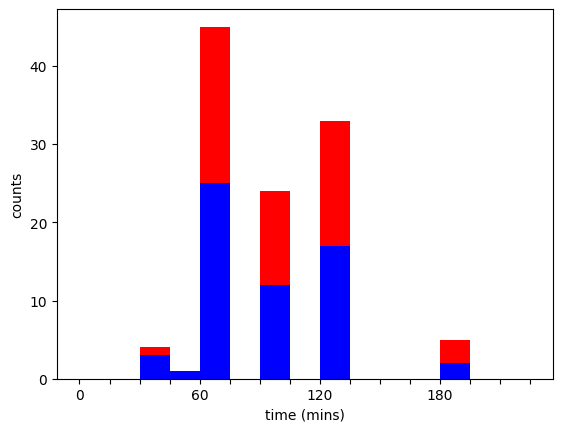

1.5103715604275976 0.1401721868605018


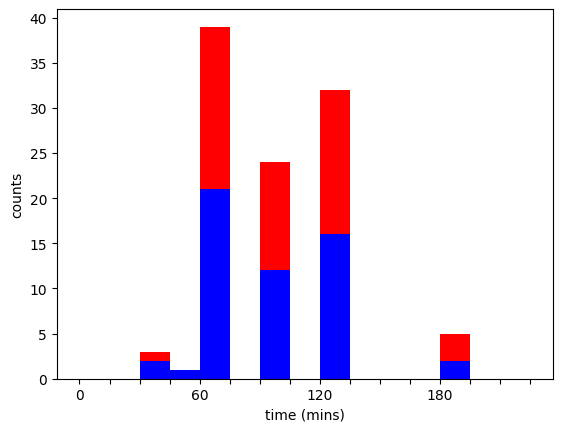

1.5103715604275976 0.11753012650478895


In [48]:
#When you go to an learning center, how much time do you spend there?
times, sexes, disabilities = GetBetterTimes(data,["education_time","education_time77" ])
lc_attendance_median, lc_attendance_medianerr = attendance(times, sexes, disabilities, WeightMF=True, OmitDisability=False)
print(lc_attendance_median/60, lc_attendance_medianerr/60)


Average over answers per unit time Sex norm


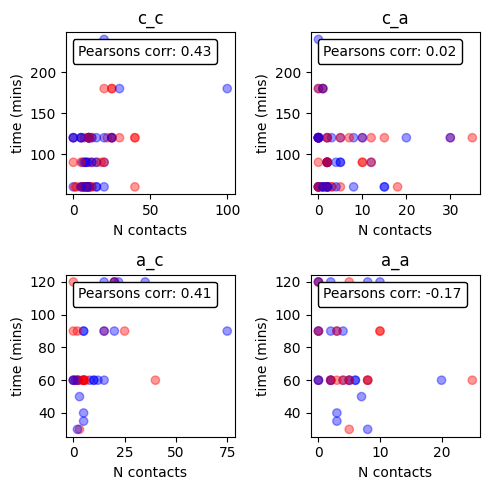

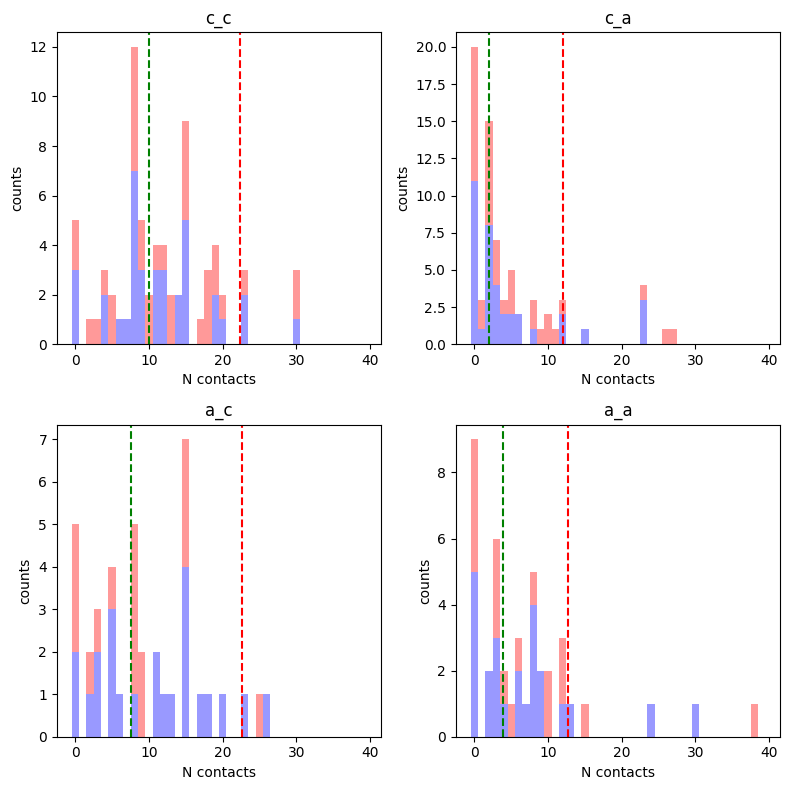

0 0 1.0 1.0 1.0
0 1 1.4408177132937035 1.4408177132937032 1.0000000000000002
1 0 0.6940503234888777 0.6940503234888779 0.9999999999999999
1 1 1.0 1.0 1.0
  learning_center:
    contacts: [[9.65,7.68],[5.33,3.92]]
    contacts_err: [[0.81,1.28],[0.89,0.86]]
    proportion_physical: [[0.12,0.12],[0.12,0.12]]
    characteristic_time: 1.51

Average over answers per unit time Sex norm remove disabled


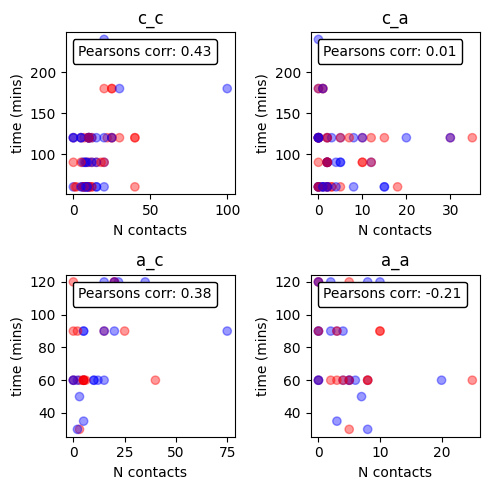

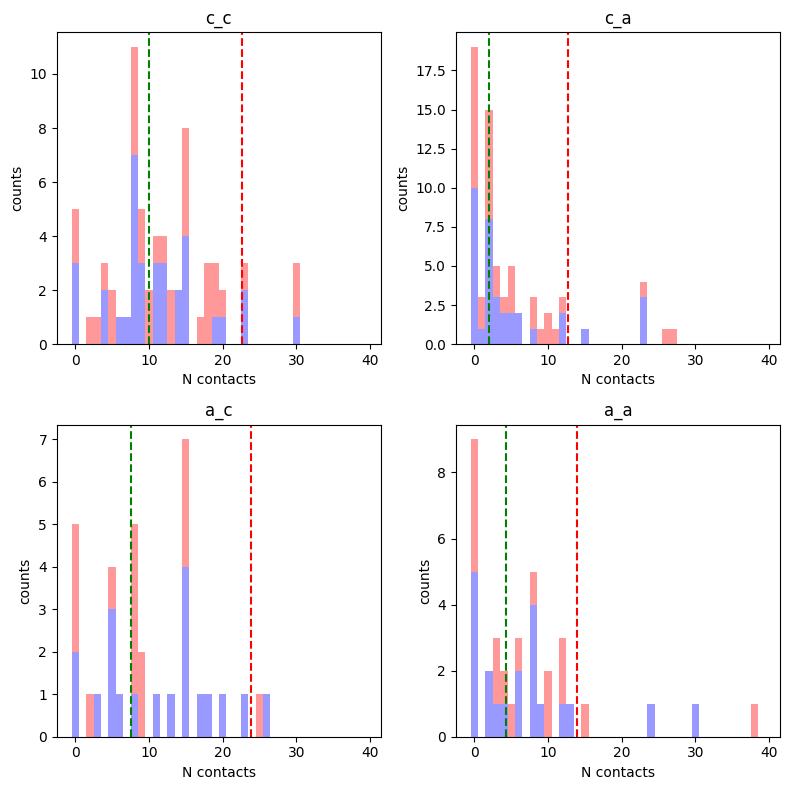

0 0 1.0 1.0 1.0
0 1 1.4408177132937032 1.4408177132937032 1.0
1 0 0.6940503234888779 0.6940503234888779 1.0
1 1 1.0 1.0 1.0
  learning_center:
    contacts: [[9.78,8.09],[5.61,4.61]]
    contacts_err: [[0.78,1.33],[0.93,0.97]]
    proportion_physical: [[0.12,0.12],[0.12,0.12]]
    characteristic_time: 1.51


In [49]:
#"When you attended formal education, approximately how many children do you come into contact with (for example, talk to)?"
#"When you attended formal education, approximately how many adults do you come into contact with (for example, talk to)?"
print("")
print("Average over answers per unit time Sex norm")
lc_contact, lc_error = contact_matrix(
    data = data,
    x = "education_contact_children",
    y = "education_contact_adults",
    WeightMF=True, 
    OmitDisability=False,
    times = np.array(times),
    norm = True, characteristic_time=lc_attendance_median
)
lc_contact, lc_error = ModifyCM(lc_contact, lc_error, Nij)
PolicyText("learning_center", lc_contact, lc_error, np.array([[0.12,0.12],[0.12,0.12]]), lc_attendance_median/60.)

print("")
print("Average over answers per unit time Sex norm remove disabled")
lc_contact, lc_error = contact_matrix(
    data = data,
    x = "education_contact_children",
    y = "education_contact_adults",
    WeightMF=True, 
    OmitDisability=True,
    times = np.array(times),
    norm = True, characteristic_time=lc_attendance_median
)
lc_contact, lc_error = ModifyCM(lc_contact, lc_error, Nij)
PolicyText("learning_center", lc_contact, lc_error, np.array([[0.12,0.12],[0.12,0.12]]), lc_attendance_median/60.)

In [50]:
#   learning_center:
#     contacts: [[10.00,2.59],[6.11,3.88]]
#     contacts_err: [[0.77,0.37],[0.87,0.88]]
#     proportion_physical: [[0.12,0.12],[0.12,0.12]]
#     characteristic_time: 1.50

# learning_center:
#     contacts: [[10.00,7.14],[4.36,3.88]]
#     contacts_err: [[0.77,1.23],[0.75,0.88]]
#     proportion_physical: [[0.12,0.12],[0.12,0.12]]
#     characteristic_time: 1.50

## Food distribution center

In [51]:
#"Do you ever go to a food distribution center?"
Nij=np.unique(data[(data["distcenter"] == "Yes") & (data["sex"] == "Male")]["age"], return_counts=True)
print(Nij)
Nij = np.array([Nij[1][2], Nij[1][0]+Nij[1][1]])
print(Nij)

(array(['Over 18 but under 60', 'Over 60', 'Under 18'], dtype=object), array([54, 29, 14]))
[14 83]


In [52]:
Nij=np.unique(data[(data["distcenter"] == "Yes") & (data["sex"] == "Female")]["age"], return_counts=True)
print(Nij)
Nij = np.array([Nij[1][2], Nij[1][0]+Nij[1][1]])
print(Nij)

(array(['Over 18 but under 60', 'Over 60', 'Under 18'], dtype=object), array([33, 20,  5]))
[ 5 53]


In [53]:
Nij=np.unique(data[(data["distcenter"] == "Yes") ]["age"], return_counts=True)
print(Nij)
Nij = np.array([Nij[1][2], Nij[1][0]+Nij[1][1]])
print(Nij)

(array(['Over 18 but under 60', 'Over 60', 'Under 18'], dtype=object), array([87, 49, 20]))
[ 20 136]


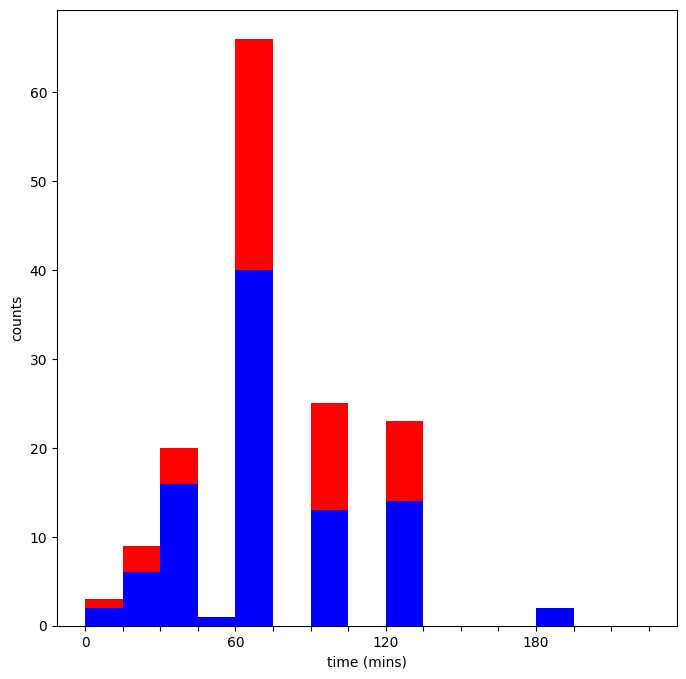

In [54]:
#When you go to a food distribution center, how much time do you spend there?
times, sexes, disabilities = GetBetterTimes(data,["distcenter_time","distcenter_time77" ])
dc_attendance_median, dc_attendance_medianerr = attendance(times, sexes, disabilities, WeightMF=True, OmitDisability=False)

In [55]:
dc_attendance_median/60., dc_attendance_medianerr/60.

(1.0069143736183983, 0.054989701633273276)

Average over answers per unit time Sex norm


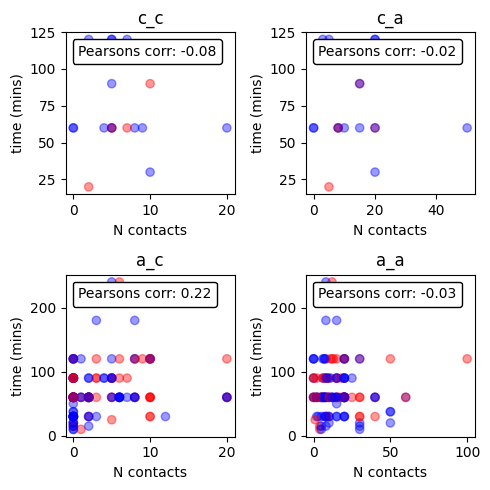

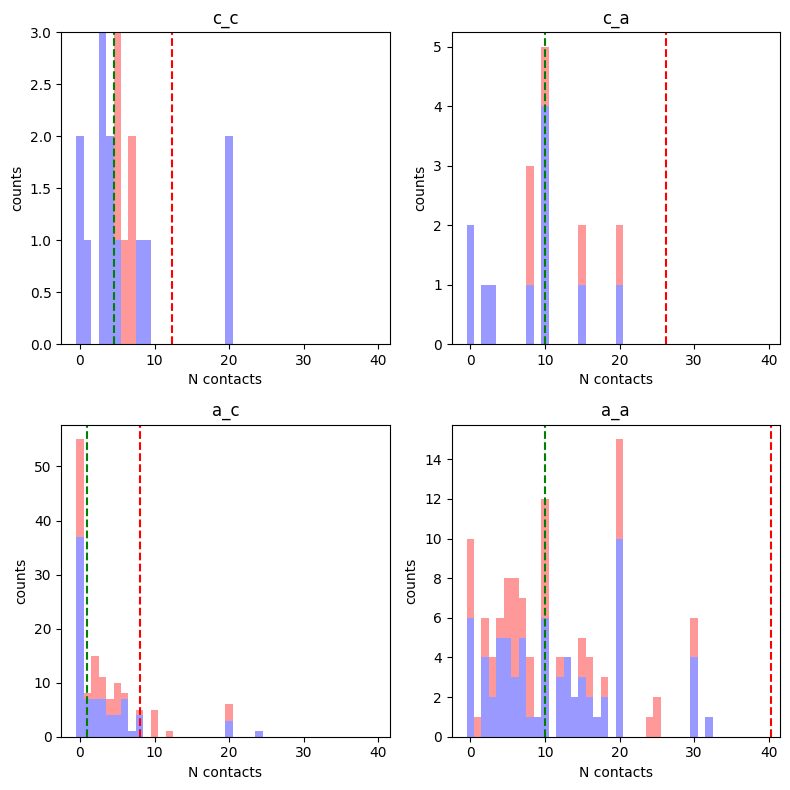

0 0 1.0 1.0 1.0
0 1 17.262368412604555 17.262368412604555 1.0
1 0 0.05792947851059792 0.057929478510597925 0.9999999999999999
1 1 1.0 1.0 1.0
  distribution_center:
    contacts: [[4.79,12.95],[0.75,9.08]]
    contacts_err: [[0.41,4.55],[0.26,0.84]]
    proportion_physical: [[0.12]]
    characteristic_time: 1.01

Average over answers per unit time Sex norm remove disabled


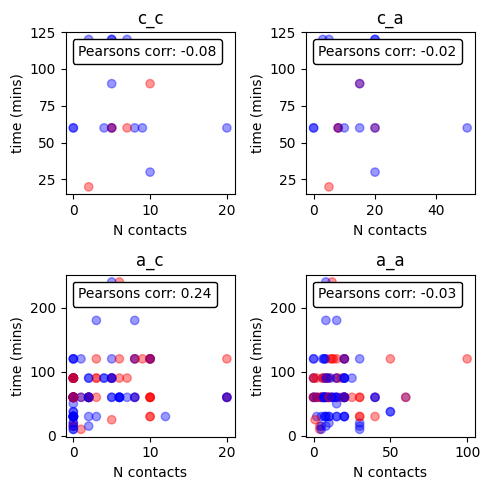

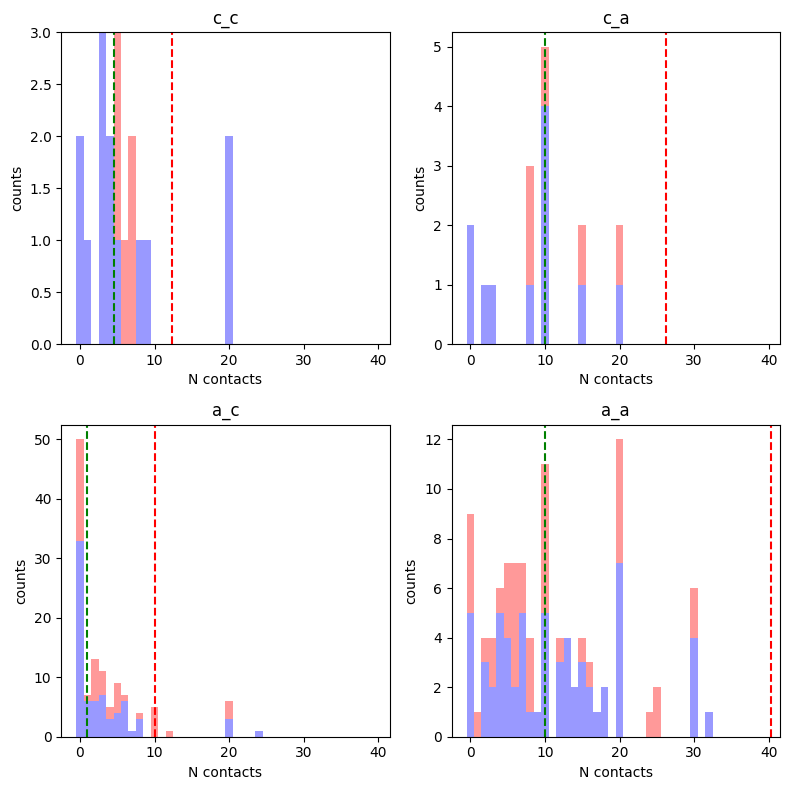

0 0 1.0 1.0 1.0
0 1 17.262368412604552 17.262368412604555 0.9999999999999998
1 0 0.05792947851059793 0.057929478510597925 1.0000000000000002
1 1 1.0 1.0 1.0
  distribution_center:
    contacts: [[4.79,16.10],[0.93,9.08]]
    contacts_err: [[0.42,4.84],[0.28,0.82]]
    proportion_physical: [[0.12]]
    characteristic_time: 1.01


In [56]:
#"When you go to a food distribution center, approximately how many children do you come into contact with at the center (for example, talk to)?",
#"When you go to a food distribution center, approximately how many adults do you come into contact with at the center (for example, talk to)?"
print("Average over answers per unit time Sex norm")
dc_contact, dc_error = contact_matrix(
    data = data,
    x = "distcenter_contact_children",
    y = "distcenter_contact_adults",
    WeightMF=True, 
    OmitDisability=False,
    times = np.array(times),
    norm = True, characteristic_time=dc_attendance_median
)
dc_contact, dc_error = ModifyCM(dc_contact, dc_error, Nij)
PolicyText("distribution_center", dc_contact, dc_error, np.array([[0.12]]), dc_attendance_median/60.)

print("")
print("Average over answers per unit time Sex norm remove disabled")
dc_contact, dc_error = contact_matrix(
    data = data,
    x = "distcenter_contact_children",
    y = "distcenter_contact_adults",
    WeightMF=True, 
    OmitDisability=True,
    times = np.array(times),
    norm = True, characteristic_time=dc_attendance_median
)

dc_contact, dc_error = ModifyCM(dc_contact, dc_error, Nij)
PolicyText("distribution_center", dc_contact, dc_error, np.array([[0.12]]), dc_attendance_median/60.)

## E-voucher outlet

In [57]:
#Do you ever go to an e-voucher outlet?
Nij=np.unique(data[(data["evoucher"] == "Yes") & (data["sex"] == "Male")]["age"], return_counts=True)
print(Nij)
Nij = np.array([Nij[1][2], Nij[1][0]+Nij[1][1]])
print(Nij)

(array(['Over 18 but under 60', 'Over 60', 'Under 18'], dtype=object), array([41, 22,  8]))
[ 8 63]


In [58]:
Nij=np.unique(data[(data["evoucher"] == "Yes") & (data["sex"] == "Female")]["age"], return_counts=True)
print(Nij)
Nij = np.array([Nij[1][2], Nij[1][0]+Nij[1][1]])
print(Nij)

(array(['Over 18 but under 60', 'Over 60', 'Under 18'], dtype=object), array([24, 16,  5]))
[ 5 40]


In [59]:
Nij=np.unique(data[(data["evoucher"] == "Yes")]["age"], return_counts=True)
print(Nij)
Nij = np.array([Nij[1][2], Nij[1][0]+Nij[1][1]])
print(Nij)

(array(['Over 18 but under 60', 'Over 60', 'Under 18'], dtype=object), array([65, 38, 13]))
[ 13 103]


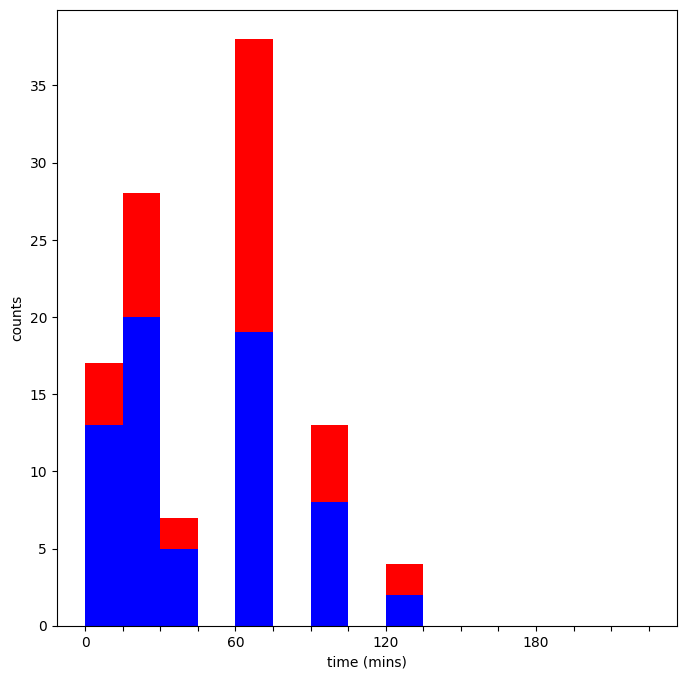

In [60]:
#When you go to a e-voucher outlet, how much time do you spend there?
times, sexes, disabilities = GetBetterTimes(data,["evoucher_time","evoucher_time77" ])
voucher_attendance_median, voucher_attendance_medianerr = attendance(times, sexes, disabilities, WeightMF=True, OmitDisability=False)

In [61]:
voucher_attendance_median/60., voucher_attendance_medianerr/60.

(0.7654118386178271, 0.11109832942627816)

Average over answers per unit time Sex norm


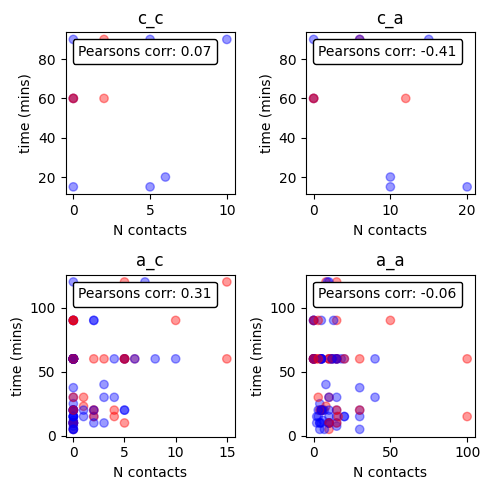

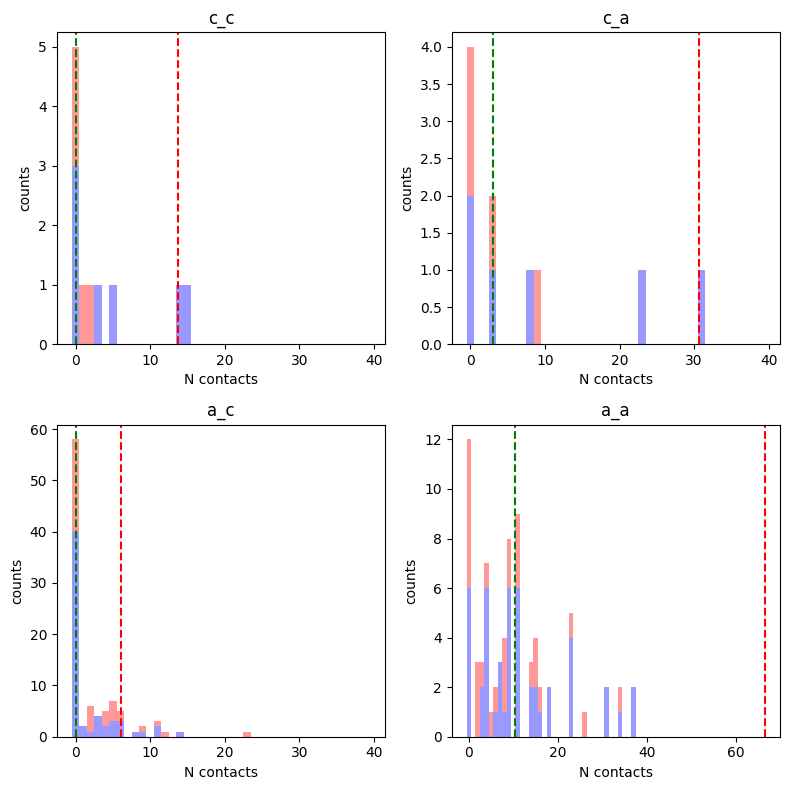

0 0 1.0 1.0 1.0
0 1 20.113393059935174 20.11339305993517 1.0000000000000002
1 0 0.049718115537251036 0.049718115537251036 1.0
1 1 1.0 1.0 1.0
  e_voucher:
    contacts: [[0.27,1.14],[0.06,9.56]]
    contacts_err: [[0.55,3.76],[0.19,1.05]]
    proportion_physical: [[0.12]]
    characteristic_time: 0.77

Average over answers per unit time Sex norm remove disabled


/tmp/ipykernel_831793/4065463341.py:21: RuntimeWarning: divide by zero encountered in double_scalars
  wij = input_cm[i,j]/input_cm[j,i]


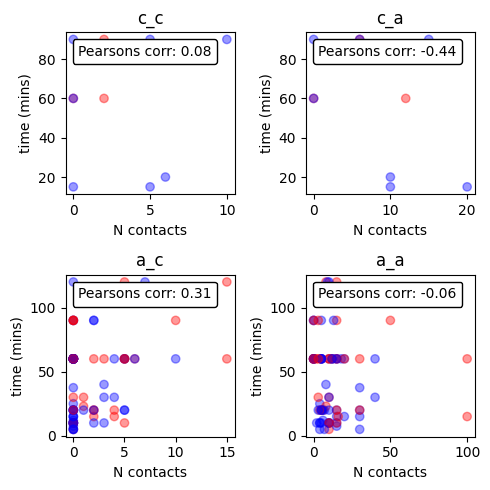

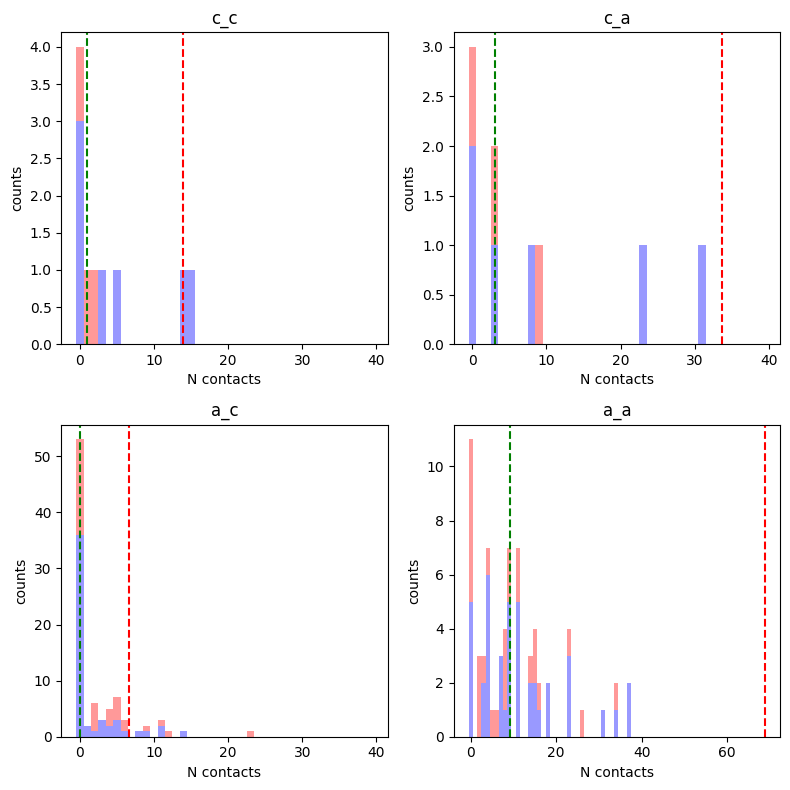

0 0 1.0 1.0 1.0
0 1 20.11339305993517 20.11339305993517 1.0
1 0 0.049718115537251036 0.049718115537251036 1.0
1 1 1.0 1.0 1.0
  e_voucher:
    contacts: [[1.15,2.10],[0.10,9.56]]
    contacts_err: [[0.88,4.68],[0.23,1.07]]
    proportion_physical: [[0.12]]
    characteristic_time: 0.77


In [62]:
#"When you go to an outlet, approximately how many children do you come into contact with at the outlet (for example, talk to)?",
#"When you go to an outlet, approximately how many adults do you come into contact with at the outlet (for example, talk to)?",
print("Average over answers per unit time Sex norm")
voucher_contact, voucher_error = contact_matrix(
    data = data,
    x = "evoucher_contact_children",
    y = "evoucher_contact_adults",
    WeightMF=True, 
    OmitDisability=False,
    times = np.array(times),
    norm = True, characteristic_time=voucher_attendance_median
)
voucher_contact, voucher_error = ModifyCM(voucher_contact, voucher_error , Nij)
PolicyText("e_voucher", voucher_contact, voucher_error, np.array([[0.12]]), voucher_attendance_median/60.)

print("")
print("Average over answers per unit time Sex norm remove disabled")
voucher_contact, voucher_error = contact_matrix(
    data = data,
    x = "evoucher_contact_children",
    y = "evoucher_contact_adults",
    WeightMF=True, 
    OmitDisability=True,
    times = np.array(times),
    norm = True, characteristic_time=voucher_attendance_median
)
voucher_contact, voucher_error = ModifyCM(voucher_contact, voucher_error , Nij)
PolicyText("e_voucher", voucher_contact, voucher_error, np.array([[0.12]]), voucher_attendance_median/60.)

## Community center

In [63]:
#Do you ever go to a community center?
Nij=np.unique(data[(data["community"] == "Yes") & (data["sex"] == "Male")]["age"], return_counts=True)
print(Nij)
Nij = np.array([Nij[1][2], Nij[1][0]+Nij[1][1]])
print(Nij)

(array(['Over 18 but under 60', 'Over 60', 'Under 18'], dtype=object), array([41, 25, 33]))
[33 66]


In [64]:
Nij=np.unique(data[(data["community"] == "Yes") & (data["sex"] == "Female")]["age"], return_counts=True)
print(Nij)
Nij = np.array([Nij[1][2], Nij[1][0]+Nij[1][1]])
print(Nij)

(array(['Over 18 but under 60', 'Over 60', 'Under 18'], dtype=object), array([32, 27, 27]))
[27 59]


In [65]:
Nij=np.unique(data[(data["community"] == "Yes") ]["age"], return_counts=True)
print(Nij)
Nij = np.array([Nij[1][2], Nij[1][0]+Nij[1][1]])
print(Nij)

(array(['Over 18 but under 60', 'Over 60', 'Under 18'], dtype=object), array([73, 52, 60]))
[ 60 125]


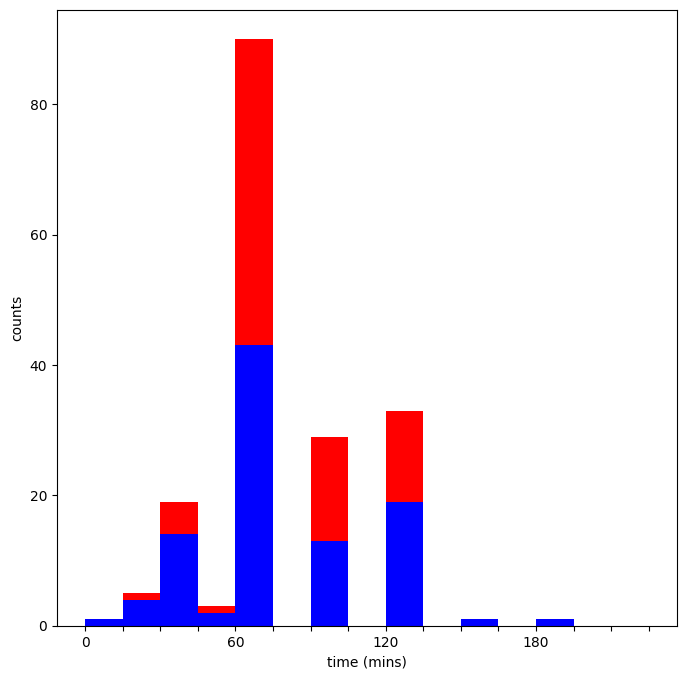

In [66]:
#When you go to a community center, how much time do you spend there?
times, sexes, disabilities = GetBetterTimes(data,["community_time","community_time77" ])
community_attendance_median, community_attendance_medianerr = attendance(times, sexes, disabilities, WeightMF=True, OmitDisability=False)

In [67]:
community_attendance_median/60., community_attendance_medianerr/60.

(1.0069143736183983, 0.024054609475504512)

Average over answers per unit time Sex norm


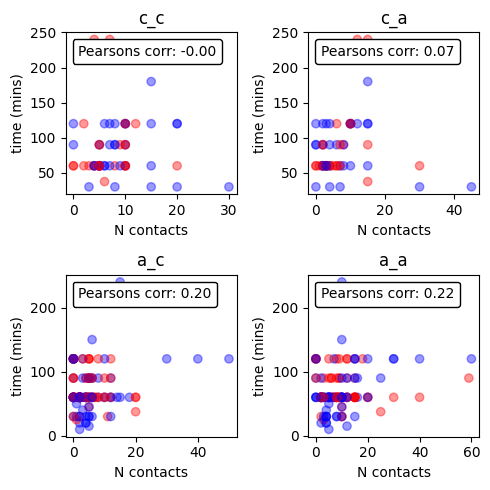

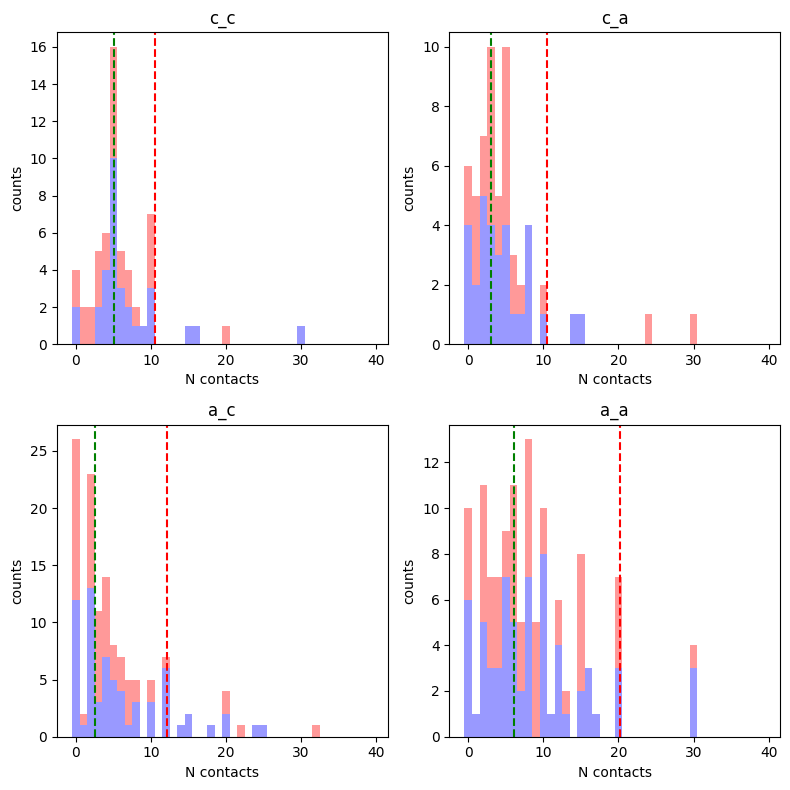

0 0 1.0 1.0 1.0
0 1 5.2887158126852185 5.288715812685219 0.9999999999999998
1 0 0.18908181785859166 0.1890818178585916 1.0000000000000002
1 1 1.0 1.0 1.0
  communal:
    contacts: [[5.07,8.48],[1.60,6.08]]
    contacts_err: [[0.23,1.21],[0.23,0.44]]
    proportion_physical: [[0.12]]
    characteristic_time: 1.01
  female_communal:
    contacts: [[5.07,8.48],[1.60,6.08]]
    contacts_err: [[0.23,1.21],[0.23,0.44]]
    proportion_physical: [[0.12]]
    characteristic_time: 1.01

Average over answers per unit time Sex norm remove disabled


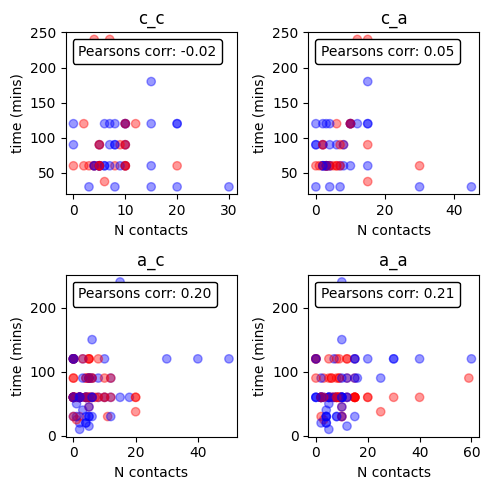

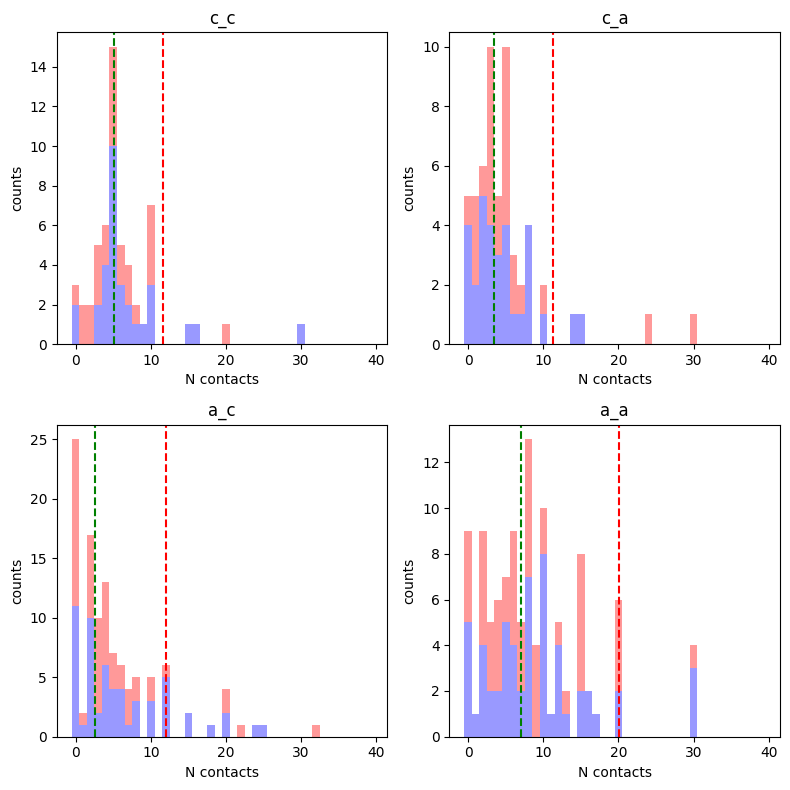

0 0 1.0 1.0 1.0
0 1 5.288715812685219 5.288715812685219 1.0
1 0 0.1890818178585916 0.1890818178585916 1.0
1 1 1.0 1.0 1.0
  communal:
    contacts: [[5.07,9.49],[1.79,7.08]]
    contacts_err: [[0.25,1.33],[0.25,0.46]]
    proportion_physical: [[0.12]]
    characteristic_time: 1.01
  female_communal:
    contacts: [[5.07,9.49],[1.79,7.08]]
    contacts_err: [[0.25,1.33],[0.25,0.46]]
    proportion_physical: [[0.12]]
    characteristic_time: 1.01


In [68]:
#"When you go to a community center, approximately how many children do you come into contact with at the center (for example, talk to)?",
#"When you go to a community center, approximately how many adults do you come into contact with at the center (for example, talk to)?"
print("Average over answers per unit time Sex norm")
community_contact, community_error = contact_matrix(
    data = data,
    x = "community_contact_children",
    y = "community_contact_adults",
    WeightMF=True, 
    OmitDisability=False,
    times = np.array(times),
    norm = True, characteristic_time=community_attendance_median
)
community_contact, community_error = ModifyCM(community_contact, community_error , Nij)
PolicyText("communal", community_contact, community_error, np.array([[0.12]]), community_attendance_median/60.)
PolicyText("female_communal", community_contact, community_error, np.array([[0.12]]), community_attendance_median/60.)


print("")
print("Average over answers per unit time Sex norm remove disabled")
community_contact, community_error = contact_matrix(
    data = data,
    x = "community_contact_children",
    y = "community_contact_adults",
    WeightMF=True, 
    OmitDisability=True,
    times = np.array(times),
    norm = True, characteristic_time=community_attendance_median
)
community_contact, community_error = ModifyCM(community_contact, community_error , Nij)
PolicyText("communal", community_contact, community_error, np.array([[0.12]]), community_attendance_median/60.)
PolicyText("female_communal", community_contact, community_error, np.array([[0.12]]), community_attendance_median/60.)

## Religious center

In [69]:
#Do you ever go to a religious meeting?
Nij=np.unique(data[(data["religious"] == "Yes") & (data["sex"] == "Male")]["age"], return_counts=True)
print(Nij)
Nij = np.array([Nij[1][2], Nij[1][0]+Nij[1][1]])
print(Nij)

(array(['Over 18 but under 60', 'Over 60', 'Under 18'], dtype=object), array([40, 41, 26]))
[26 81]


In [70]:
Nij=np.unique(data[(data["religious"] == "Yes") & (data["sex"] == "Female")]["age"], return_counts=True)
print(Nij)
Nij = np.array([Nij[1][2], Nij[1][0]+Nij[1][1]])
print(Nij)

(array(['Over 18 but under 60', 'Over 60', 'Under 18'], dtype=object), array([37, 34, 18]))
[18 71]


In [71]:
Nij=np.unique(data[(data["religious"] == "Yes") ]["age"], return_counts=True)
print(Nij)
Nij = np.array([Nij[1][2], Nij[1][0]+Nij[1][1]])
print(Nij)

(array(['Over 18 but under 60', 'Over 60', 'Under 18'], dtype=object), array([77, 75, 45]))
[ 45 152]


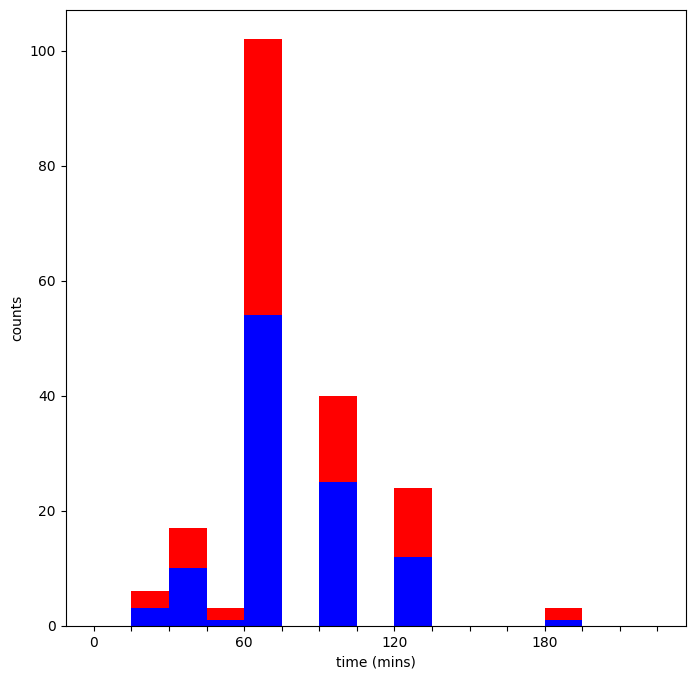

In [72]:
#When you go to a religious meeting, how much time do you spend there?
times, sexes, disabilities = GetBetterTimes(data,["religious_time","religious_time_77" ])
religious_attendance_median, religious_attendance_medianerr= attendance(times, sexes, disabilities, WeightMF=True, OmitDisability=False)

In [73]:
religious_attendance_median/60., religious_attendance_medianerr/60.

(1.0069143736183983, 0.009511668290075565)

Average over answers per unit time Sex norm remove disabled


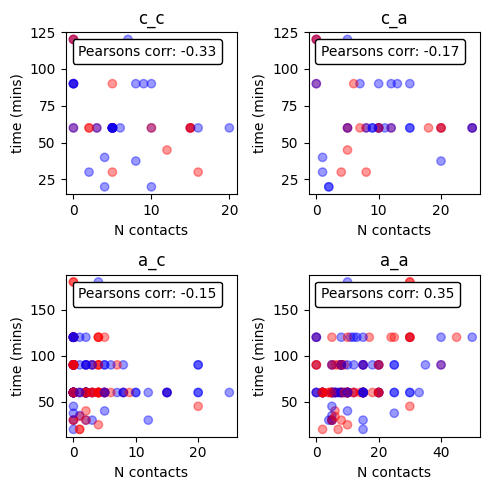

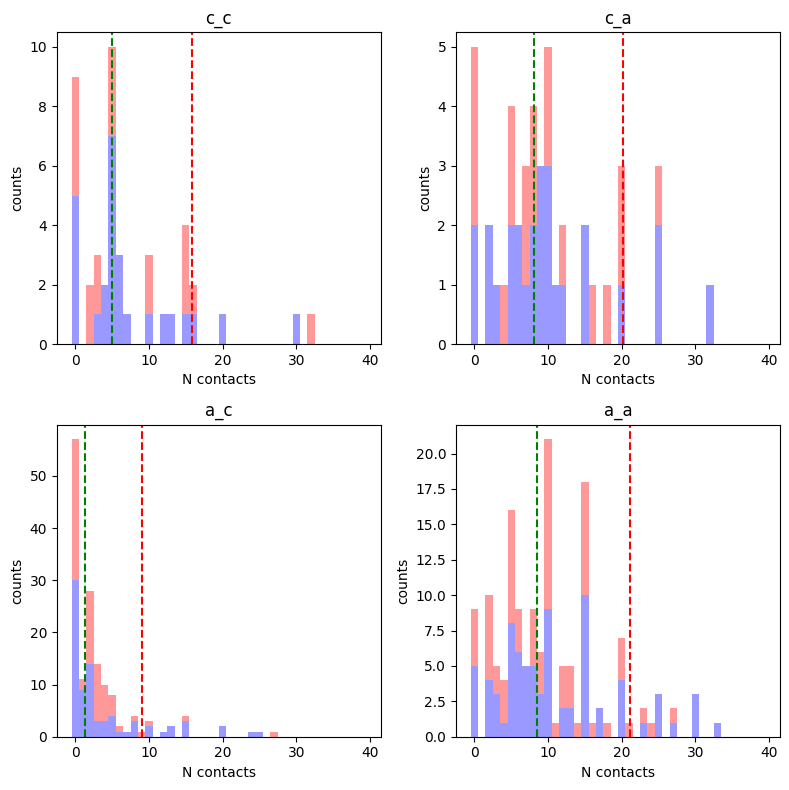

0 0 1.0 1.0 1.0
0 1 8.574771237633636 8.574771237633636 1.0
1 0 0.11662118700159846 0.11662118700159844 1.0000000000000002
1 1 1.0 1.0 1.0
  religious:
    contacts: [[4.63,10.40],[1.21,8.90]]
    contacts_err: [[0.70,1.70],[0.20,0.51]]
    proportion_physical: [[0.12]]
    characteristic_time: 1.01

Average over answers per unit time Sex norm


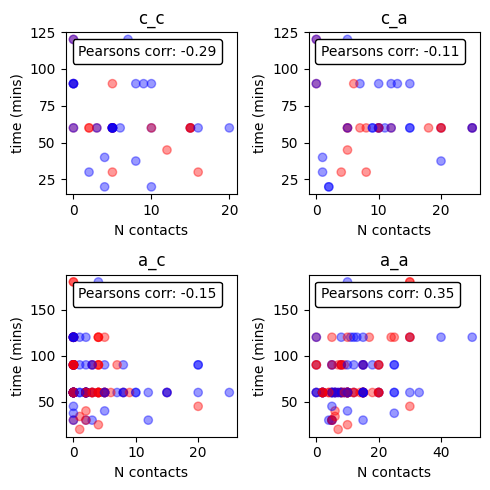

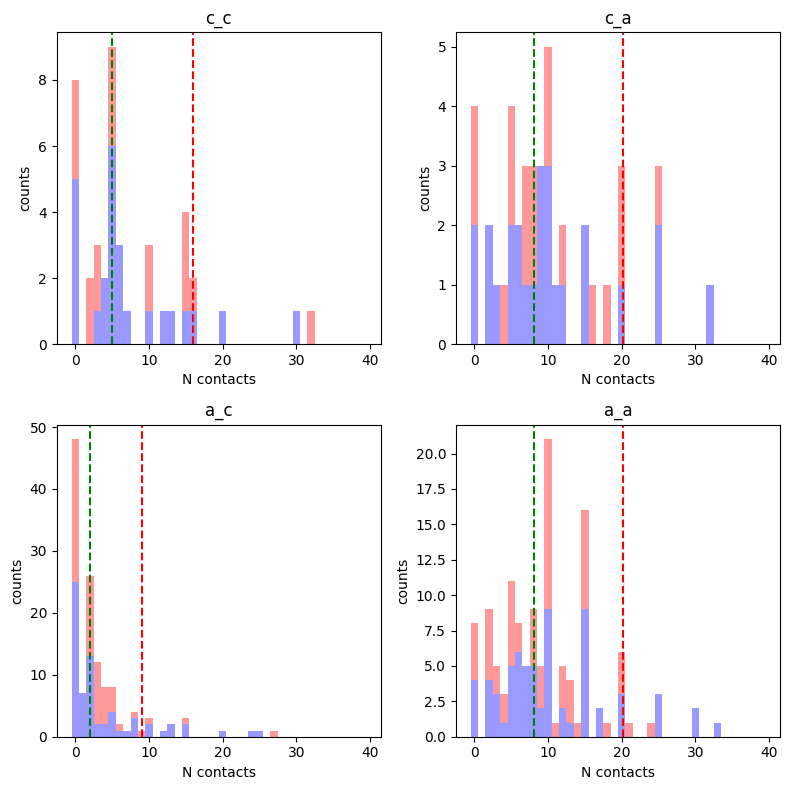

0 0 1.0 1.0 1.0
0 1 8.574771237633637 8.574771237633636 1.0000000000000002
1 0 0.11662118700159843 0.11662118700159844 0.9999999999999999
1 1 1.0 1.0 1.0
  religious:
    contacts: [[5.07,10.53],[1.23,8.78]]
    contacts_err: [[0.79,1.66],[0.19,0.48]]
    proportion_physical: [[0.12]]
    characteristic_time: 1.01


In [74]:
#"When you go to a religious meeting, approximately how many children do you come into contact with at the meeting (for example, talk to)?",
#"When you go to religious meeting, approximately how many adults do you come into contact with at the meeting (for example, talk to)?"
print("Average over answers per unit time Sex norm remove disabled")
religious_contact, religious_error = contact_matrix(
    data = data,
    x = "religious_contact_children",
    y = "religious_contact_adults",
    WeightMF=True, 
    OmitDisability=False,
    times = np.array(times),
    norm = True, characteristic_time=religious_attendance_median
)

religious_contact, religious_error = ModifyCM(religious_contact, religious_error , Nij)
PolicyText("religious", religious_contact, religious_error, np.array([[0.12]]), religious_attendance_median/60.)

print("")
print("Average over answers per unit time Sex norm")
religious_contact, religious_error = contact_matrix(
    data = data,
    x = "religious_contact_children",
    y = "religious_contact_adults",
    WeightMF=True, 
    OmitDisability=True,
    times = np.array(times),
    norm = True, characteristic_time=religious_attendance_median
)
religious_contact, religious_error = ModifyCM(religious_contact, religious_error , Nij)
PolicyText("religious", religious_contact, religious_error, np.array([[0.12]]), religious_attendance_median/60.)

## Hand pump and latrine

In [75]:
Nij=np.unique(data[(data["pump_children"] != None) ]["age"], return_counts=True)
print(Nij)
Nij = np.array([Nij[1][2], Nij[1][0]+Nij[1][1]])
print(Nij)

(array(['Over 18 but under 60', 'Over 60', 'Under 18'], dtype=object), array([115, 102,  92]))
[ 92 217]


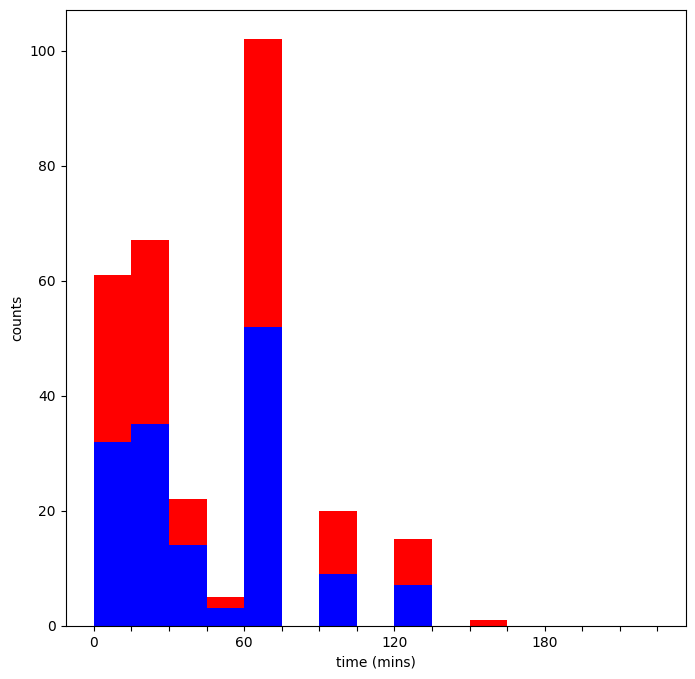

In [76]:
#When you go to a water pump or latrine, how much time do you spend there?
times, sexes, disabilities = GetBetterTimes(data,["pump_time","pump_time77" ])
pump_latrine_attendance_median, pump_latrine_attendance_medianerr = attendance(times, sexes, disabilities, WeightMF=True, OmitDisability=False)

In [77]:
pump_latrine_attendance_median/60., pump_latrine_attendance_medianerr/60. 

(0.6780936213482845, 0.13957476056106874)

Average over answers per unit time Sex norm


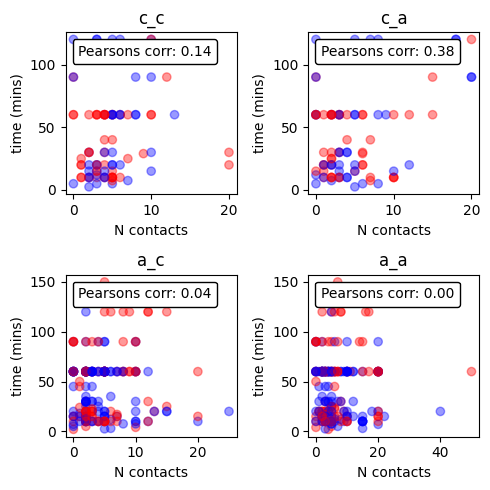

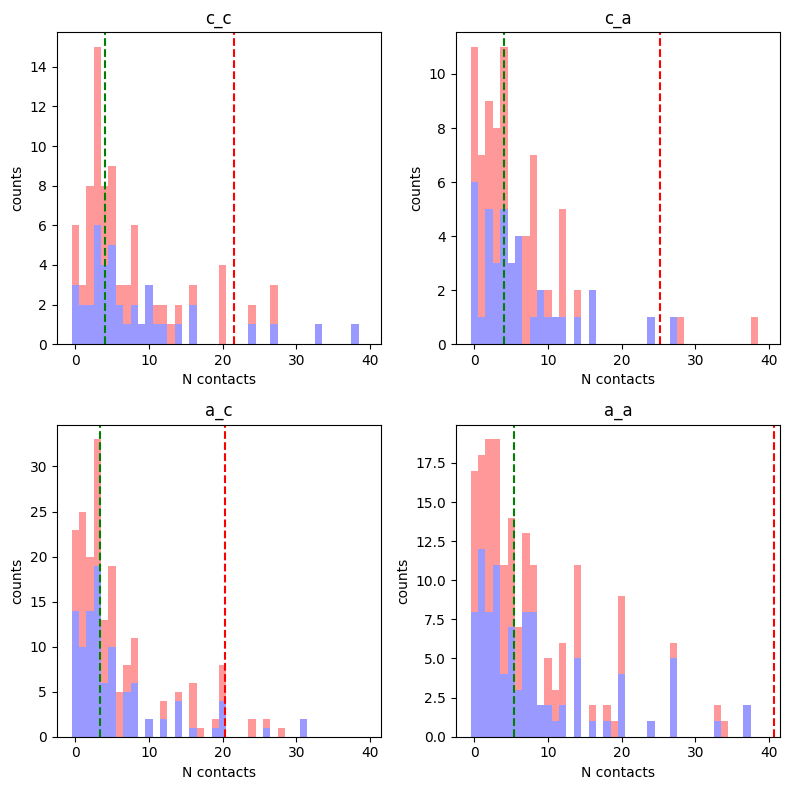

0 0 1.0 1.0 1.0
0 1 5.987746076622744 5.987746076622743 1.0000000000000002
1 0 0.16700775002870996 0.16700775002870996 1.0
1 1 1.0 1.0 1.0
  pump_latrine:
    contacts: [[4.53,11.75],[1.96,5.11]]
    contacts_err: [[0.42,0.84],[0.14,0.41]]
    proportion_physical: [[0.02]]
    characteristic_time: 0.68

Average over answers per unit time Sex norm remove disabled


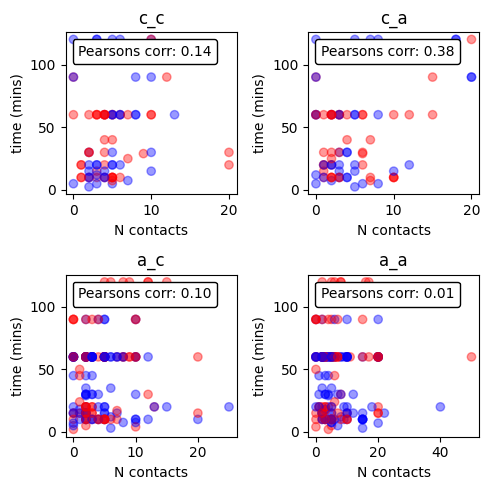

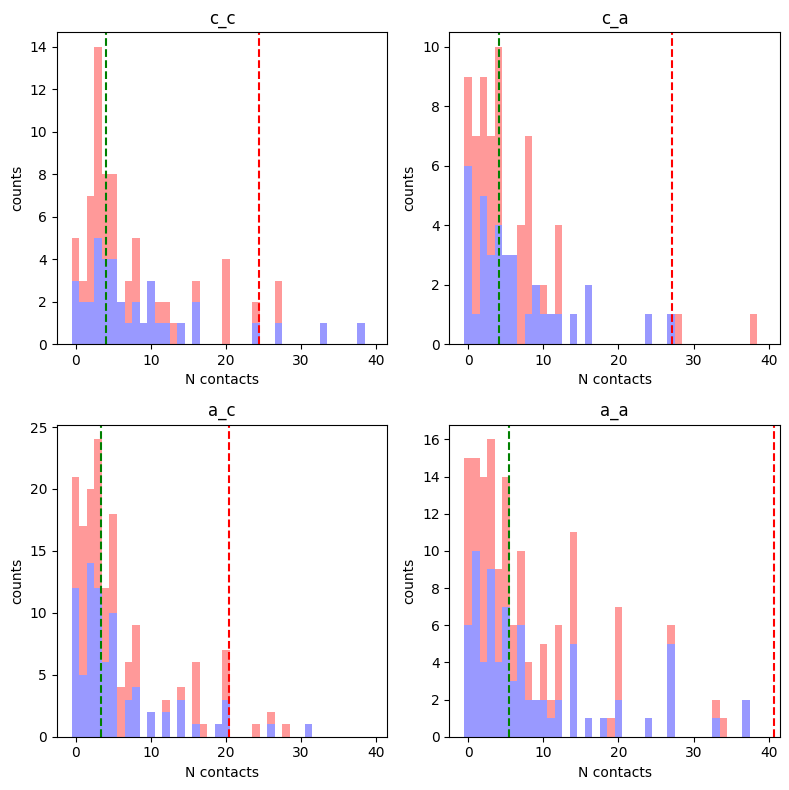

0 0 1.0 1.0 1.0
0 1 5.987746076622743 5.987746076622743 1.0
1 0 0.16700775002870996 0.16700775002870996 1.0
1 1 1.0 1.0 1.0
  pump_latrine:
    contacts: [[4.53,12.27],[2.05,5.11]]
    contacts_err: [[0.42,1.03],[0.17,0.40]]
    proportion_physical: [[0.02]]
    characteristic_time: 0.68


In [78]:
#"When you go to a water pump or latrine, approximately how many children do you come into contact with(for example, talk to)?",
#"When you go to water pump or latrine, approximately how many adults do you come into contact with(for example, talk to)?"
print("Average over answers per unit time Sex norm")
pump_latrine_contact, pump_latrine_error = contact_matrix(
    data = data,
    x = "pump_children",
    y = "pump_adults",
    WeightMF=True, 
    OmitDisability=False,
    times = np.array(times),
    norm = True, characteristic_time=pump_latrine_attendance_median
)

pump_latrine_contact, pump_latrine_error = ModifyCM(pump_latrine_contact, pump_latrine_error , Nij)
PolicyText("pump_latrine", pump_latrine_contact, pump_latrine_error, np.array([[0.02]]), pump_latrine_attendance_median/60.)


print("")
print("Average over answers per unit time Sex norm remove disabled")
pump_latrine_contact, pump_latrine_error = contact_matrix(
    data = data,
    x = "pump_children",
    y = "pump_adults",
    WeightMF=True, 
    OmitDisability=True,
    times = np.array(times),
    norm = True, characteristic_time=pump_latrine_attendance_median
)
pump_latrine_contact, pump_latrine_error = ModifyCM(pump_latrine_contact, pump_latrine_error , Nij)
PolicyText("pump_latrine", pump_latrine_contact, pump_latrine_error, np.array([[0.02]]), pump_latrine_attendance_median/60.)

In [85]:
#Learning Center
print("Learning Center", f"{lc_attendance_median/60:.4g}", f"{lc_attendance_medianerr/60:.1g}")
#FD center
print("Distribution Center", f"{dc_attendance_median/60.:.4g}", f"{dc_attendance_medianerr/60.:.1g}")
#Voucher
print("e voucher", f"{voucher_attendance_median/60.:.4g}", f"{voucher_attendance_medianerr/60.:.1g}")
#Community center
print("Comunity Centers", f"{community_attendance_median/60.:.4g}", f"{community_attendance_medianerr/60.:.1g}")
#Relgious center
print("Religious", f"{religious_attendance_median/60.:.4g}", f"{religious_attendance_medianerr/60.:.1g}")
#Pump latrine
print("Pump Latrine", f"{pump_latrine_attendance_median/60.:.4g}", f"{pump_latrine_attendance_medianerr/60. :.1g}")

Learning Center 1.51 0.1
Distribution Center 1.007 0.05
e voucher 0.7654 0.1
Comunity Centers 1.007 0.02
Religious 1.007 0.01
Pump Latrine 0.6781 0.1
